In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,mlxtend,matplotlib,scikit-learn

Sebastian Raschka 
last updated: 2016-07-25 

CPython 3.5.1
IPython 5.0.0

numpy 1.11.1
mlxtend 0.4.2.dev0
matplotlib 1.5.1
scikit-learn 0.17.1


---

This Jupyter notebook contains the code to create the data visualizations for the article "Model evaluation, model selection, and algorithm selection in machine learning - Part II" at http://sebastianraschka.com/blog/2016/model-evaluation-selection-part2.html.

---

# Confidence Intervals via Holdout and K-fold

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Holdout method and binomial approximation

In [3]:
from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

iris = load_iris()
X, y = iris.data[:, [1, 2]], iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=12345,
                                                    stratify=y)

clf_1 = KNeighborsClassifier(n_neighbors=3,
                             weights='uniform', 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             p=2, 
                             metric='minkowski', 
                             metric_params=None, 
                             n_jobs=1)

y_pred_1 = clf_1.fit(X_train, y_train).predict(X_test)
y_pred_1_acc = np.mean(y_test == y_pred_1)

y_pred_1_var = (y_pred_1_acc * (1. - y_pred_1_acc)) / y_pred_1.shape[0]
y_pred_1_std = np.sqrt(y_pred_1_var)
y_pred_1_ci95 = 1.96 * y_pred_1_std

print(y_pred_1_acc)
print(y_pred_1_var)
print(y_pred_1_std)
print(y_pred_1_ci95)

0.933333333333
0.00138271604938
0.0371848900682
0.0728823845336


## Holdout method and repeated sampling

0.932444444444
0.000809086419753
0.0284444444444
0.00788439774507
0.866666666667
1.0


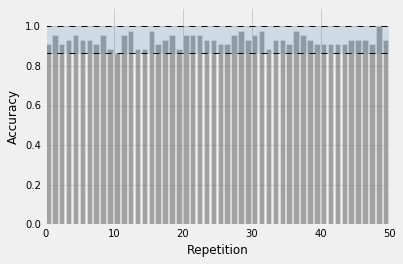

In [4]:
rng = np.random.RandomState(seed=12345)
seeds = np.arange(10**5)
rng.shuffle(seeds)
seeds = seeds[:50]

pred_2 = []

for i in seeds:
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, 
                                                        random_state=i,
                                                        stratify=y)
    y_pred_i = clf_1.fit(X_train, y_train).predict(X_test)
    y_pred_i_acc = np.mean(y_test == y_pred_i)
    pred_2.append(y_pred_i_acc)

pred_2 = np.asarray(pred_2)
pred_2_mean = pred_2.mean()
pred_2_var = pred_2.var()
pred_2_std = pred_2.std()
pred_2_ci95 = 1.96 * pred_2_std / np.sqrt(len(seeds))

print(pred_2_mean)
print(pred_2_var)
print(pred_2_std)
print(pred_2_ci95)
print(pred_2.min())
print(pred_2.max())

with plt.style.context(('fivethirtyeight')):
    plt.bar(range(0, pred_2.shape[0]), pred_2, color='gray', alpha=0.7)
    plt.axhline(1, color='k', linewidth=1, linestyle='--')
    plt.axhline(pred_2.min(), color='k', linewidth=1, linestyle='--')
    plt.axhspan(pred_2.min(), pred_2.max(), alpha=0.2, color='steelblue')
    plt.ylim([0, pred_2.max() + 0.1])
    plt.xlabel('Repetition')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig('figures/model-eval-iris_0.svg')

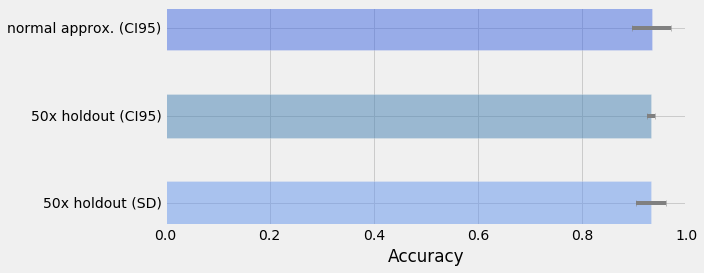

In [5]:
means = [y_pred_1_acc, pred_2_mean, pred_2_mean][::-1]
ci = [y_pred_1_std, pred_2_ci95, pred_2_std][::-1]
colors = ['royalblue', 'steelblue', 'cornflowerblue'][::-1]
hatches = ['/', '//', '\\'][::-1]
labels = ['normal approx. (CI95)',
          '50x holdout (CI95)',
          '50x holdout (SD)'][::-1]


with plt.style.context(('fivethirtyeight')):
    fig, ax = plt.subplots(figsize=(10, 4))
    for i, c in enumerate(colors):
        rects1 = ax.barh(bottom=[i+1], 
                         width=[means[i]], 
                         height=0.5,
                         alpha=0.5,
                         ecolor='gray',
                         color=c,
                         #hatch=hatches[i],
                         xerr=ci[i])

    ax.set_yticks(np.arange(1, len(labels)+1) + 0.25)
    ax.set_yticklabels(labels)
    plt.xlim([0.0, 1.0])
    ax.set_xlabel('Accuracy')
    plt.tight_layout()
    plt.savefig('figures/model-eval-iris_1.svg')
    plt.show()

## Pessimistic Bias in Holdout

In [6]:
from mlxtend.data import mnist_data

X2, y2 = mnist_data()
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2,
                                                    test_size=0.3, 
                                                    random_state=12,
                                                    stratify=y2)
y_train2

array([8, 8, 7, ..., 6, 9, 8])

In [7]:
from sklearn.linear_model import LogisticRegression

clf_2 = LogisticRegression(penalty='l2', 
                           dual=False, 
                           tol=0.0001, 
                           C=0.000001, 
                           fit_intercept=True, 
                           intercept_scaling=1, 
                           class_weight=None, 
                           random_state=12, 
                           solver='lbfgs', 
                           max_iter=100, 
                           multi_class='multinomial', 
                           verbose=0, 
                           warm_start=False, 
                           n_jobs=1)

pred_train, pred_test = [], []

intervals = np.arange(500, X_train2.shape[0] + 1, 200)

for i in intervals:
    clf_2.fit(X_train2[:i], y_train2[:i])
    p_train = clf_2.score(X_train2[:i], y_train2[:i])
    p_test = clf_2.score(X_test2, y_test2)
    pred_train.append(p_train)
    pred_test.append(p_test)

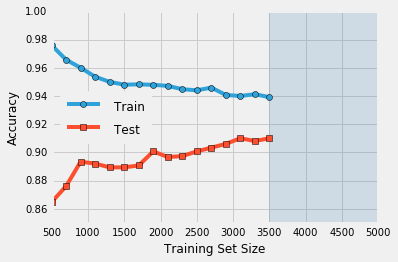

In [8]:
with plt.style.context(('fivethirtyeight')):
    plt.plot(intervals, pred_train, marker='o', label='Train')
    plt.plot(intervals, pred_test, marker='s', label='Test')
    plt.legend(loc='best', numpoints=1)
    plt.xlim([500, X_train2.shape[0] + X_test2.shape[0]])
    plt.axvspan(X_train2.shape[0], 
                X_train2.shape[0] + X_test2.shape[0], 
                alpha=0.2, 
                color='steelblue')
    plt.ylim([0.85, 1.0])
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig('figures/model-eval-mnist_0.svg')

## K-fold and standard deviation (1-standard error method)

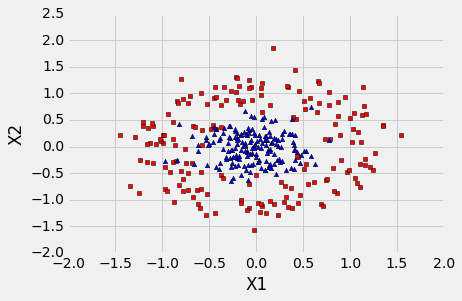

In [9]:
from sklearn.datasets import make_circles


with plt.style.context(('fivethirtyeight')):
    X, y = make_circles(n_samples=500, random_state=123, noise=0.25, factor=0.2)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.3, 
                                                        random_state=12345,
                                                        stratify=y)

    plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], marker='s', color='red', edgecolor='k')
    plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], marker='^', color='blue', edgecolor='k')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.savefig('figures/model-eval-circles_1.svg')
    plt.show()

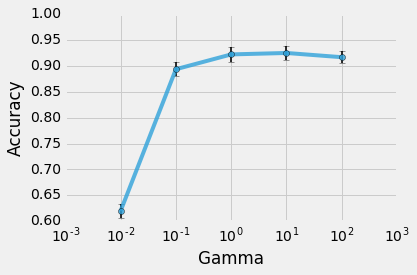

In [10]:
from sklearn.svm import SVC
from sklearn.cross_validation import StratifiedKFold

params = [0.01, 0.1, 1.0, 10.0, 100.0]
cv_acc, cv_std, cv_stderr = [], [], []


cv = StratifiedKFold(y=y_train, n_folds=10, shuffle=True, random_state=123)

for c in params:

    clf = SVC(C=1.0, 
              kernel='rbf', 
              degree=1, 
              gamma=c, 
              coef0=0.0, 
              shrinking=True, 
              probability=False, 
              tol=0.001, 
              cache_size=200, 
              class_weight=None, 
              verbose=False, 
              max_iter=-1, 
              decision_function_shape=None, 
              random_state=123)

    
    all_acc = []
    for train_index, valid_index in cv:
        pred = clf.fit(X_train[train_index], y_train[train_index])\
               .predict(X_train[valid_index])
        acc = np.mean(y_train[valid_index] == pred)
        all_acc.append(acc)

    all_acc = np.array(all_acc)
    y_pred_cv10_mean = all_acc.mean()
    y_pred_cv10_std = all_acc.std()
    y_pred_cv10_stderr = y_pred_cv10_std / np.sqrt(10)

    cv_acc.append(y_pred_cv10_mean) 
    cv_std.append(y_pred_cv10_std)
    cv_stderr.append(y_pred_cv10_stderr)
    

with plt.style.context(('fivethirtyeight')):
    
    ax = plt.subplot(111)
    ax.set_xscale('log')
    ax.errorbar(params, cv_acc, yerr=cv_stderr, marker='o', alpha=0.8, ecolor='black', elinewidth=2)

    plt.ylim([0.6, 1.0])
    plt.xlim([0.001, 1000.0])
    plt.xlabel('Gamma')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig('figures/model-eval-circles_2.svg')
    plt.show()

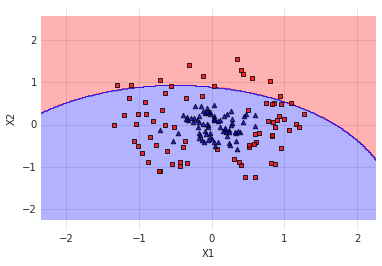

In [11]:
from mlxtend.evaluate import plot_decision_regions

clf = SVC(C=1.0, 
          kernel='rbf', 
          degree=1, 
          gamma=0.01, 
          coef0=0.0, 
          shrinking=True, 
          probability=False, 
          tol=0.001, 
          cache_size=200, 
          class_weight=None, 
          verbose=False, 
          max_iter=-1, 
          decision_function_shape=None, 
          random_state=123)

clf.fit(X_train, y_train)

with plt.style.context(('seaborn-whitegrid')):
    plot_decision_regions(X_test, 
                          y_test, 
                          clf=clf, 
                          res=0.02, 
                          legend=None)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.savefig('figures/model-eval-circles_3.svg')
    plt.show()

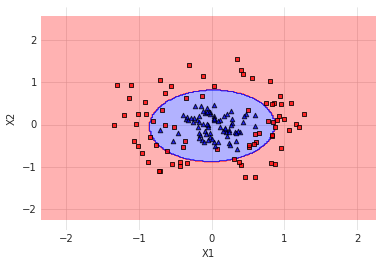

In [12]:
clf = SVC(C=1.0, 
          kernel='rbf', 
          degree=1, 
          gamma=0.1, 
          coef0=0.0, 
          shrinking=True, 
          probability=False, 
          tol=0.001, 
          cache_size=200, 
          class_weight=None, 
          verbose=False, 
          max_iter=-1, 
          decision_function_shape=None, 
          random_state=123)

clf.fit(X_train, y_train)
with plt.style.context(('seaborn-whitegrid')):
    plot_decision_regions(X_test, 
                          y_test, 
                          clf=clf, 
                          res=0.02, 
                          legend=None)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.savefig('figures/model-eval-circles_4.svg')
    plt.show()

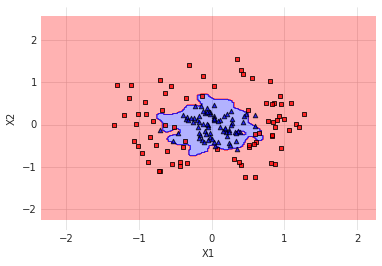

In [13]:
clf = SVC(C=1.0, 
          kernel='rbf', 
          degree=1, 
          gamma=100, 
          coef0=0.0, 
          shrinking=True, 
          probability=False, 
          tol=0.001, 
          cache_size=200, 
          class_weight=None, 
          verbose=False, 
          max_iter=-1, 
          decision_function_shape=None, 
          random_state=123)

clf.fit(X_train, y_train)
with plt.style.context(('seaborn-whitegrid')):
    plot_decision_regions(X_test, 
                          y_test, 
                          clf=clf, 
                          res=0.02, 
                          legend=None)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.savefig('figures/model-eval-circles_5.svg')
    plt.show()

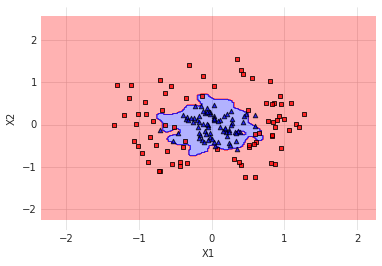

In [14]:
clf = SVC(C=1.0, 
          kernel='rbf', 
          degree=1, 
          gamma=100, 
          coef0=0.0, 
          shrinking=True, 
          probability=False, 
          tol=0.001, 
          cache_size=200, 
          class_weight=None, 
          verbose=False, 
          max_iter=-1, 
          decision_function_shape=None, 
          random_state=123)

clf.fit(X_train, y_train)
with plt.style.context(('seaborn-whitegrid')):
    plot_decision_regions(X_test, 
                          y_test, 
                          clf=clf, 
                          res=0.02, 
                          legend=None)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.savefig('figures/model-eval-circles_6.svg')
    plt.show()

## Repeated k-fold

In [15]:
rng = np.random.RandomState(seed=12345)
seeds = np.arange(10**5)
rng.shuffle(seeds)
seeds = seeds[:5]

params = [0.01, 0.1, 1.0, 10.0, 100.0]
cv_acc, cv_std, cv_stderr = [], [], []

params_by_seed = []
for seed in seeds:
    cv = StratifiedKFold(y=y_train, n_folds=10, 
                         shuffle=True, random_state=seed)
    acc_by_param = []
    for c in params:
        
        clf = SVC(C=1.0, 
                  kernel='rbf', 
                  degree=1, 
                  gamma=c, 
                  coef0=0.0, 
                  shrinking=True, 
                  probability=False, 
                  tol=0.001, 
                  cache_size=200, 
                  class_weight=None, 
                  verbose=False, 
                  max_iter=-1, 
                  decision_function_shape=None, 
                  random_state=123)


        all_acc = []
        for train_index, valid_index in cv:
            pred = clf.fit(X_train[train_index], y_train[train_index])\
                   .predict(X_train[valid_index])
            acc = np.mean(y_train[valid_index] == pred)
            all_acc.append(acc)

        all_acc = np.array(all_acc)
        acc_by_param.append(all_acc.mean())
    print(acc_by_param)
    params_by_seed.append(acc_by_param)

[0.62352941176470578, 0.90065359477124185, 0.92042483660130725, 0.92892156862745101, 0.90555555555555567]
[0.60277777777777786, 0.89673202614379088, 0.9254901960784313, 0.93137254901960775, 0.90816993464052287]
[0.60816993464052282, 0.90326797385620916, 0.92320261437908502, 0.9285947712418301, 0.91421568627450989]
[0.62875816993464062, 0.89787581699346419, 0.91715686274509811, 0.92892156862745101, 0.91421568627450989]
[0.60506535947712403, 0.90310457516339882, 0.92614379084967324, 0.92026143790849679, 0.91437908496732023]


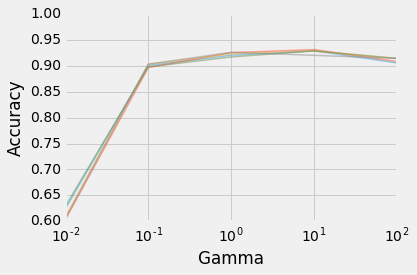

In [16]:
with plt.style.context(('fivethirtyeight')):
    ax = plt.subplot(111)
    ax.set_xscale('log')
    
    for cv_acc in params_by_seed:
        ax.errorbar(params, cv_acc, linewidth=1.5, alpha=0.5)

    plt.ylim([0.6, 1.0])
    plt.xlabel('Gamma')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.savefig('figures/model-eval-circles_7.svg')
    plt.show()